# Proceedural Dungeon Maker 

Based loosley off of [this article](http://www.roguebasin.com/index.php?title=Grid_Based_Dungeon_Generator) and  [Donjon](https://donjon.bin.sh/code/dungeon/).  My goal is to make a similar thing, but with better layout and hallway planning... for making above-ground maps in other programs.  Ideally you select an outline, either word-based like [Donjon](https://donjon.bin.sh/fantasy/dungeon/index.cgi) or from some sort of file system, then you select a few things and let the maker go house.

### Step 1: the Grid

According to [this site](http://www.roguebasin.com/index.php?title=Grid_Based_Dungeon_Generator):
> The first step in the process (after creating an array to hold the data values) is to create a grid that will be used to create the rooms of the dungeon. The grid is composed of logical units called cells. The cells define the maximum extent of a room, as well as its position on the map. Since the example array is quite small, the cells will be defined with a size of 5.

I will use groups of 50 pixels to define a cell.  If there is a constraint on size (or a picture to insert), I will do so here.  For now, however, I will pick an 800 by 800 pixel space to make my life easier.

Grid Components:
* cell_size_5ft_squares
* cell_size - size of cell in pixels
* x - x size (in pixels)
* y - y size (in pixels)

In [10]:
import numpy as np



# 1 pixel = 1 ft
cell_size_5ft_squares = 15
cell_size = 5 * cell_size_5ft_squares

# overall space
x = 5*cell_size
y = 10*cell_size


np.zeros((x+20, y+20))

# make a dictionary of valid cells... this saves on computational time later
cells_dict = {}
for n, i in enumerate(range(10, x + 10 - cell_size, cell_size)):
    for m, j in enumerate(range(10, y + 10 - cell_size, cell_size)):
        cells_dict[(n, m)] = [(i, j), (i+cell_size, j+cell_size)]

# make a numpy array of all our pixels...
pixel_array = np.zeros((x+20,y+20), dtype='float')
print(len(cells_dict))


36


Now to place rooms...

Room variables:
* number_of_rooms - how many rooms to place.
* min_rooms - if random, minimum to place
* min_room_size - min 5ft squares to make a room
* grid - True to show a grid
* room_dict - key = [(xcell, ycell)], [x_size, y_size, (starting_coords)]

In [11]:
import random as rnd

lst = list(cells_dict.keys())
min_rooms = 3
number_of_rooms = rnd.randint(min_rooms,int((len(lst)-1)))
min_room_size = 6
grid = True
room_dict = {}

for i in range(number_of_rooms):
    j = rnd.randint(0, len(lst) - 1)
    try:
        room_dict[lst[j]]
    except:
        size_x = rnd.randint(min_room_size, cell_size_5ft_squares - 2)
        size_y = rnd.randint(min_room_size, cell_size_5ft_squares - 2)
        x_co, y_co = cells_dict[lst[j]][0]
        x_pos = x_co + 5*(2 + rnd.randint(0, cell_size_5ft_squares - 2 - size_x))
        y_pos = y_co + 5*(2 + rnd.randint(0, cell_size_5ft_squares - 2 - size_y))
        # draw it
        room_dict[lst[j]] = [x_pos + int(size_x*5/2.0), y_pos + int(size_y*5/2.0)]
        for xd in range(x_pos, x_pos + size_x*5):
            for yd in range(y_pos, y_pos + size_y*5):
                pixel_array[xd, yd] = 1.0
                if grid and ((xd % 5 == 0) or (yd % 5 ==0)):
                    pixel_array[xd, yd] = 0.75
print(room_dict)

{(2, 7): [192, 585], (0, 1): [60, 112], (1, 3): [117, 285], (2, 0): [215, 60], (1, 1): [135, 130], (2, 1): [185, 127], (0, 2): [57, 195]}


Add halls...
* hall_width - 1 or 2
* connectivity - percent chane the room connects to more than one other room

In [12]:
from math import sqrt
hall_width = 1
straitness = int(x/(cell_size))

# figure out how lose the rooms are to each other... using middle coordinate
dist_dict = {}
for key in room_dict:
    dist_dict[key] = [(-1,-1), (x*y)**2]
    for key2 in room_dict:
        if key2 != key and ((key2 not in dist_dict.keys()) or (dist_dict[key][0] == (-1, -1))):
            dist = sqrt((room_dict[key][0] - room_dict[key2][0])**2 +
                        (room_dict[key][1] - room_dict[key2][1])**2)
            if dist < dist_dict[key][1]:
                dist_dict[key][0] = key2
                dist_dict[key][1] = dist
# now we have who goes where...
for start in dist_dict.keys():
    finish = dist_dict[start][0]
    location = room_dict[start]
    # get it in the middle of a square 
    while location[0] % 5*hall_width != 0:
        location[0] = location[0] + 1
    while location[1] % 5*hall_width != 0:
        location[1] = location[1] + 1
    destination = room_dict[finish]
    # get it in the middle of a square
    while destination[0] % 5*hall_width != 0:
        destination[0] = destination[0] - 1
    while destination[1] % 5*hall_width != 0:
        destination[1] = destination[1] - 1
    # now we have our locations...
    # direction to start should be easiest to get there...
    if abs(location[0] - destination[0]) < abs(location[1] - destination[1]):
        direction = 0
        other = 1
    else:
        direction = 1
        other = 0
    # lets do this thing
    step_size = 5*hall_width
    dist = sqrt((location[0] - destination[0])**2 +
                (location[1] - destination[1])**2)
    while dist > (5*hall_width):
        # take a step
        if location[direction] - destination[direction] > 0:
            direction_sign = -1
        else:
            direction_sign = 1
        # draw a a hallway-sized cube... 
        for loc_step in range(step_size*rnd.randint(1,straitness)):
            location[direction] = location[direction] + direction_sign
            for step in range(step_size):
                d = [0, 0]
                d[direction] = location[direction]
                d[other] = location[other] - step*direction_sign
                pixel_array[d[0], d[1]] = 1.0
                if grid and ((d[0] % 5 == 0) or (d[1] % 5 ==0)):
                    pixel_array[d[0], d[1]] = 0.75
        # check for a twist...
        if abs(location[0] - destination[0]) < abs(location[1] - destination[1]):
            direction = 1
            other = 0
        else:
            direction = 0
            other = 1
        dist = sqrt((location[0] - destination[0])**2 +
                (location[1] - destination[1])**2)


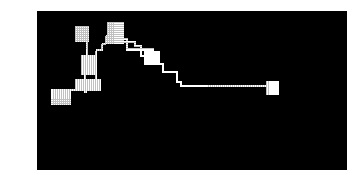

In [13]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(int(1.5*x/100), int(1.5*y/100)), dpi= 80, facecolor='w', edgecolor='k')
plt.axis('off')
plt.imshow(pixel_array, cmap="gist_gray")
plt.show()